In [1]:
import sys
sys.path.append('../kgeo')
sys.path.append('../bhnerf')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils, emission_utils, visualization, network_utils
from kerr_raytracing_ana import raytrace_ana
from kerr_raytracing_utils import angular_turning, radial_roots, mino_total, my_sign
import scipy.special as sp

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import jax
import ipyvolume as ipv
from ipywidgets import interact
import time
import ipywidgets as widgets
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xsfdbdk7 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



# Volume rendering

In [38]:
# Generate hotspot emission (fancy, 4 sheared + 4 new hotspots)
nt, nx, ny, nz = 128, 128, 128, 128
r_isco = 3.0 

phi = 0.0            # azimuth angle (ccw from x-axis)
theta = np.pi/3      # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame_single = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

nspots = 4
frame_subset_inds = [60, 75, 105, 0]  # Generated by np.random.choice(range(0, 128, 5), size=nspots) with np.random.seed(0)
# Sum over rotated positions of n_spots
initial_frame_nspots = emission_utils.generate_orbit_3d(initial_frame_single, nt, 1, rot_axis).isel(
    t=frame_subset_inds).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

# Shear initial hotspots
emission_sheared = emission_utils.generate_orbit_3d(initial_frame_nspots, nt, velocity_field, rot_axis)

# Select base frame from sheared hotspots
base_timestep = nt // 4
initial_frame_sheared = emission_sheared.isel(t=base_timestep)

# Generate new rotated hotspots
nspots_new = 4
frame_subset_inds_new = [25, 55, 60, 40]  # Generated by np.random.choice(range(0, 128, 5), size=nspots) with np.random.seed(1)
# Sum over rotated positions of n_spots
initial_frame_new = emission_utils.generate_orbit_3d(initial_frame_single, nt, 1, rot_axis).isel(
    t=frame_subset_inds_new).sum('t')

# Add fancy base frame
initial_frame_fancy = initial_frame_new + initial_frame_sheared

# Shear fancy emission
emission = emission_utils.generate_orbit_3d(initial_frame_fancy, nt, velocity_field, rot_axis)

print('rotation axis: {}'.format(rot_axis))

rotation axis: [ 0.5        0.        -0.8660254]


In [4]:
extent = [(float(emission[dim].min()), float(emission[dim].max())) for dim in ('x', 'y', 'z')]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

In [39]:
# Perspective camera functions
def normalize(x):
    """Normalization helper function."""
    return x / np.linalg.norm(x)

def viewmatrix(lookdir, up, position):
    """Construct lookat view matrix."""
    vec2 = normalize(lookdir)
    vec0 = normalize(np.cross(up, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, position], axis=1)
    return m

def generate_hemispherical_orbit(radius, n_frames=120):
    """Calculates a render path which orbits around the z-axis."""
    # Assume that z-axis points up towards approximate camera hemisphere
    render_poses = []

    up = np.array([0., 0., 1.])
    for theta in np.linspace(0., 2. * np.pi, n_frames):
        camorigin = radius * np.array(
            [np.cos(theta), np.sin(theta), 0.])
        render_poses.append(viewmatrix(camorigin, up, camorigin))

    render_poses = np.stack(render_poses, axis=0)
    return render_poses

def generate_elevated_orbit(radius, height, n_frames=120):
    """Calculates a render path which orbits around the z-axis."""
    # Assume that z-axis points up towards approximate camera hemisphere
    render_poses = []
    
    orbit_radius = np.sqrt(radius**2 - height**2)

    up = np.array([0., 0., 1.])
    for theta in np.linspace(0., 2. * np.pi, n_frames):
        camorigin = np.array(
            [orbit_radius * np.cos(theta), orbit_radius * np.sin(theta), height])
        render_poses.append(viewmatrix(camorigin, up, camorigin))

    render_poses = np.stack(render_poses, axis=0)
    return render_poses

def generate_rays(camtoworlds, width, height, focal):
    """Generating rays for all images."""
    x, y = np.meshgrid(  # pylint: disable=unbalanced-tuple-unpacking
        np.arange(width, dtype=np.float32),  # X-Axis (columns)
        np.arange(height, dtype=np.float32),  # Y-Axis (rows)
        indexing='xy')
    camera_dirs = np.stack(
        [(x - width * 0.5 + 0.5) / focal,
         -(y - height * 0.5 + 0.5) / focal, -np.ones_like(x)],
        axis=-1)
    directions = ((camera_dirs[None, ..., None, :] *
                   camtoworlds[:, None, None, :3, :3]).sum(axis=-1))
    origins = np.broadcast_to(camtoworlds[:, None, None, :3, -1],
                              directions.shape)

    return origins, directions

def sample_along_rays(rays_o, rays_d, near, far, num_samples):
    t_vals = jnp.linspace(near, far, num_samples)
    pts = rays_o[:, :, :, None, :] + t_vals[None, None, None, :, None] * rays_d[:, :, :, None, :]
    return pts

def draw_cube(emission, pts):
    facewidth = 10.
    linewidth = 0.1
#     linecolor = jnp.array([1000.0, 1000.0, 1000.0])
    linecolor = jnp.array([0.0, 0.0, 0.0, 1000.0])
    vertices = jnp.array([[-facewidth/2., -facewidth/2., -facewidth/2.],
                        [facewidth/2., -facewidth/2., -facewidth/2.],
                        [-facewidth/2., facewidth/2., -facewidth/2.],
                        [facewidth/2., facewidth/2., -facewidth/2.],
                        [-facewidth/2., -facewidth/2., facewidth/2.],
                        [facewidth/2., -facewidth/2., facewidth/2.],
                        [-facewidth/2., facewidth/2., facewidth/2.],
                        [facewidth/2., facewidth/2., facewidth/2.]])
    dirs = jnp.array([[-1., 0., 0.],
                      [1., 0., 0.],
                      [0., -1., 0.],
                      [0., 1., 0.],
                      [0., 0., -1.],
                      [0., 0., 1.]])
    
    cm = plt.get_cmap('hot')
    emission_cm = cm(emission)
    emission_cm = jnp.clip(emission_cm - 0.05, 0.0, 1.0)
    
    emission_cm = jnp.concatenate([emission_cm[..., :3], emission[..., None] / jnp.amax(emission)], axis=-1)
    
#     emission = jnp.where(jnp.less(jnp.broadcast_to(emission[..., 0, None], emission.shape), 0.1), 
#                          jnp.zeros_like(emission), emission)

    for i in range(vertices.shape[0]):

        for j in range(dirs.shape[0]):
            # Draw line segments from each vertex
            line_seg_pts = vertices[i, None, :] + jnp.linspace(0.0, facewidth, 64)[:, None] * dirs[j, None, :]

            for k in range(line_seg_pts.shape[0]):
                dists = jnp.linalg.norm(pts - jnp.broadcast_to(line_seg_pts[k, None, None, None, :], pts.shape), axis=-1)
                # out = jnp.where(jnp.less_equal(dists, linewidth),
                #                 lineval * jnp.exp(-1. * dists), out)
                emission_cm += linecolor[None, None, None, :] * jnp.exp(-1. * dists / linewidth ** 2)[..., None]
    
    out = jnp.where(jnp.greater(jnp.broadcast_to(jnp.amax(jnp.abs(pts), axis=-1, keepdims=True), 
                                                 emission_cm.shape), 
                                facewidth/2. + linewidth), 
                    jnp.zeros_like(emission_cm), emission_cm)
        
    return out

def alpha_composite(emission, dists, pts, inside_halfwidth=4.5):
    emission = np.clip(emission, 0., 1.)
    color = emission[..., :-1] * dists[0, ..., None]
    alpha = emission[..., -1:] 
    
    inside = np.where(np.less(np.amax(np.abs(pts), axis=-1), inside_halfwidth), 
                      np.ones_like(pts[..., 0]),
                      np.zeros_like(pts[..., 0]))
    
    rendering = np.zeros_like(color[:, :, 0, :])
    acc = np.zeros_like(color[:, :, 0, 0])
    outside_acc = np.zeros_like(color[:, :, 0, 0])
    for i in range(alpha.shape[-2]):
        ind = alpha.shape[-2] - i - 1
        
        # if pixels inside cube, don't alpha composite
        rendering = rendering + inside[..., ind, None] * color[..., ind, :]
        
        # if pixels not inside cube, alpha composite      
        outside_alpha = alpha[..., ind, :] * (1. - inside[..., ind, None])
        rendering = rendering * (1. - outside_alpha) + color[..., ind, :] * outside_alpha 
        
        acc = alpha[..., ind, 0] + (1. - alpha[..., ind, 0]) * acc
        outside_acc = outside_alpha[..., 0] + (1. - outside_alpha[..., 0]) * outside_acc
        
    rendering += np.array([1., 1., 1.])[None, None, :] * (1. - acc[..., None])
    return rendering, outside_acc

In [40]:
x_res_vis = 256
y_res_vis = 256
z_res_vis = 256

poses = generate_elevated_orbit(25., 0., n_frames=60)
height = y_res_vis
width = x_res_vis
focal = .5 * width / jnp.tan(.5 * 0.7)
rays_o, rays_d = generate_rays(poses, width, height, focal)
pts = sample_along_rays(rays_o, rays_d, 15., 35., z_res_vis)

i = 5
x_vis = pts[i, :, :, :, 0]
y_vis = pts[i, :, :, :, 1]
z_vis = pts[i, :, :, :, 2]
d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                         jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                         axis=3), axis=-1)

In [42]:
images = []
for t in [0, 25]:
    emission_vis = emission.isel(t=t).interp(x=xr.DataArray(x_vis),
                                             y=xr.DataArray(y_vis),
                                             z=xr.DataArray(z_vis)).fillna(0.0).data
    
    print('rendering cube visualization...')
    t0 = time.time()
    emission_vis_cube = draw_cube(emission_vis, jnp.stack([x_vis, y_vis, z_vis], axis=-1))
    rendering_gt, _ = alpha_composite(emission_vis_cube, d_vis, pts[i, ...])
    print('rendering time [secs]: {}'.format(time.time() - t0))
    rendering_gt = jnp.clip(rendering_gt, 0.0, 1.0)
    images.append(rendering_gt)

rendering cube visualization...
rendering time [secs]: 319.74284315109253
rendering cube visualization...
rendering time [secs]: 320.1367907524109


In [44]:
%matplotlib widget
fig, axes = plt.subplots(1,2, figsize=(8,4))
for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(images[i])
plt.tight_layout()

plt.savefig('figures/approach_illustration_volumes.pdf', transparent=False, bbox_inches=0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### DEBUG

rendering cube visualization...
rendering time [secs]: 11.643578052520752


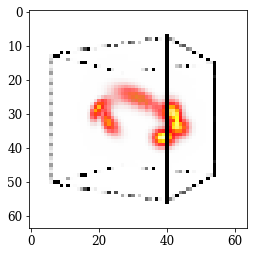

In [33]:
x_res_vis = 64
y_res_vis = 64
z_res_vis = 64

poses = generate_elevated_orbit(25., 0., n_frames=60)
height = y_res_vis
width = x_res_vis
focal = .5 * width / jnp.tan(.5 * 0.7)
rays_o, rays_d = generate_rays(poses, width, height, focal)
pts = sample_along_rays(rays_o, rays_d, 15., 35., z_res_vis)

i = 5
x_vis = pts[i, :, :, :, 0]
y_vis = pts[i, :, :, :, 1]
z_vis = pts[i, :, :, :, 2]
d_vis = jnp.linalg.norm(jnp.concatenate([jnp.diff(pts[i:i+1, ...], axis=3),
                                         jnp.zeros_like(pts[i:i+1, :, :, -1:])], 
                                         axis=3), axis=-1)

t=0
emission_vis = emission.isel(t=t).interp(x=xr.DataArray(x_vis),
                                         y=xr.DataArray(y_vis),
                                         z=xr.DataArray(z_vis)).fillna(0.0).data

print('rendering cube visualization...')
t0 = time.time()
emission_vis_cube = draw_cube(emission_vis, jnp.stack([x_vis, y_vis, z_vis], axis=-1))
rendering_gt, _ = alpha_composite(emission_vis_cube, d_vis, pts[i, ...])
print('rendering time [secs]: {}'.format(time.time() - t0))
rendering_gt = jnp.clip(rendering_gt, 0.0, 1.0)

plt.figure()
plt.imshow(rendering_gt)

rendering cube visualization...
rendering time [secs]: 14.078919410705566


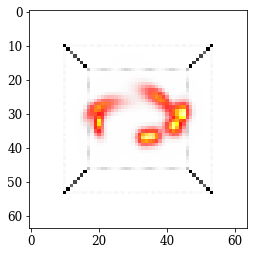

# Ray tracing 

In [13]:
sensor = raytrace_ana(a=0.0, th_o=np.pi/2, plotdata=True)

calculating preliminaries...
integrating in theta...9.21 s
integrating in r...13.96 s
plotting data...


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

done!


In [26]:
ROUT = 1000 #4.e10 # sgra distance in M
NGEO = 200
NPIX = 200
EP = 1.e-12
MAXTAUFRAC = (1. - 1.e-10) # NOTE: if we go exactly to tau_tot t and phi diverge on horizon
MINSPIN = 1.e-6 # minimum spin for full formulas to work before taking limits.

def plotgeos(sensor, xlim=10, rmax=12):
    ngeo = NGEO
    sensor = sensor.transpose('geo', 'pix')
    a, th_o, r_o, r_s, th_s, ph_s, alpha, beta = \
    float(sensor['spin'].data), float(sensor['inc'].data), sensor['r_o'].data, sensor['r'].data, \
    sensor['theta'].data, sensor['phi'].data, sensor['alpha'].data, sensor['beta'].data

    # conserved quantities
    lam = -alpha*np.sin(th_o)
    eta = (alpha**2 - a**2)*np.cos(th_o)**2 + beta**2

    # spin zero should have no voritical geodesics
    if(a<MINSPIN and np.any(eta<0)):
        eta[eta<0]=EP # TODO ok?
        print("WARNING: there were eta<0 points for spin %f<MINSPIN!"%a)

    # angular turning points
    (u_plus, u_minus, th_plus, th_minus, thclass) = angular_turning(a, th_o, lam, eta)

    # sign of final angular momentum
    s_o = my_sign(beta)

    # radial roots and radial motion case
    (r1, r2, r3, r4, rclass) = radial_roots(a, lam, eta)

    # total Mino time to infinity
    tau_tot = mino_total(a, r_o, eta, r1, r2, r3, r4)

    # find the steps in tau
    # go to taumax in the same number of steps on each ray -- step dtau depends on the ray
    dtau = MAXTAUFRAC*tau_tot / (ngeo - 1)
    tausteps = np.linspace(0, MAXTAUFRAC*tau_tot, ngeo) # positive back from screen in GL19b conventions

    # find the number of poloidal orbits as a function of time (GL 19b Eq 35)
    # Only applies for normal geodesics eta>0
    if(a<MINSPIN):
        uratio = 0.
        a2u_minus = -(eta+lam**2)
    else:
        uratio = u_plus/u_minus
        a2u_minus = a**2 * u_minus

    K = sp.ellipk(uratio) # gives NaN for eta<0
    n_all = (np.sqrt(-a2u_minus.astype(complex))*tausteps)/(4*K)
    n_all = np.real(n_all.astype(complex))
    n_tot = n_all[-1]

    # fractional number of equatorial crossings
    # Only applies for normal geodesics eta>0
    F_o = sp.ellipkinc(np.arcsin(np.cos(th_o)/np.sqrt(u_plus)), uratio) # gives NaN for eta<0
    Nmax_eq = ((tau_tot*np.sqrt(-a2u_minus.astype(complex)) + s_o*F_o) / (2*K))  + 1
    Nmax_eq[beta>=0] -= 1
    Nmax_eq = np.floor(np.real(Nmax_eq.astype(complex)))
    Nmax_eq[np.isnan(Nmax_eq)] = 0
    
    rplus  = 1 + np.sqrt(1-a**2)
        
    # convert to cartesian for plotting
    x_s = r_s * np.cos(ph_s) * np.sin(th_s)
    y_s = r_s * np.sin(ph_s) * np.sin(th_s)
    z_s = r_s * np.cos(th_s)

    fig = plt.figure( figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
    ax.plot_surface(rplus*np.cos(u) * np.sin(v),  rplus*np.sin(u) * np.sin(v),  rplus*np.cos(v), color='black')

    rr, thth = np.mgrid[0:xlim, 0:2*np.pi:20j]
    xx = rr*np.cos(thth); yy = rr*np.sin(thth)
    zz = np.zeros(xx.shape)
    #ax.plot_surface(xx, yy, zz, alpha=0.5)
    ax.set_xlim(-xlim,xlim)
    ax.set_ylim(-xlim,xlim)
    ax.set_zlim(-xlim,xlim)
    ax.auto_scale_xyz([-xlim, xlim], [-xlim, xlim], [-xlim, xlim])
    ax.set_axis_off()

    x_o = 1.5*rmax * np.cos(0) * np.sin(th_o)
    y_o = 1.5*rmax * np.sin(0) * np.sin(th_o)
    z_o = 1.5*rmax * np.cos(th_o)
    ax.plot3D([0,x_o],[0,y_o],[0,z_o],'black',ls='dashed')

    maxwraps = int(np.nanmax(Nmax_eq))
    colors = ['k','b','g','orange','r','m']
    NPLOT=50
    for j in range(maxwraps+1):
        mask = (Nmax_eq==j)
        color = colors[j]
        xs = x_s[:,mask];ys = y_s[:,mask];zs = z_s[:,mask];rs = r_s[:,mask];
        nplot = int(np.ceil(NPLOT*xs.shape[-1]/NPIX))
        if xs.shape[-1] < 5 or j>=3:
            geos = range(xs.shape[-1])
        else:
            geos = range(0,xs.shape[-1],xs.shape[-1]//nplot)

        for i in geos:
            x = xs[:,i]; y=ys[:,i]; z=zs[:,i]
            mask = rs[:,i] < rmax
            x = x[mask]; y = y[mask]; z = z[mask]
            ax.plot3D(x,y,z,color)
            
    ax.plot_wireframe(X, Y, Z, color='black')
    return fig, ax

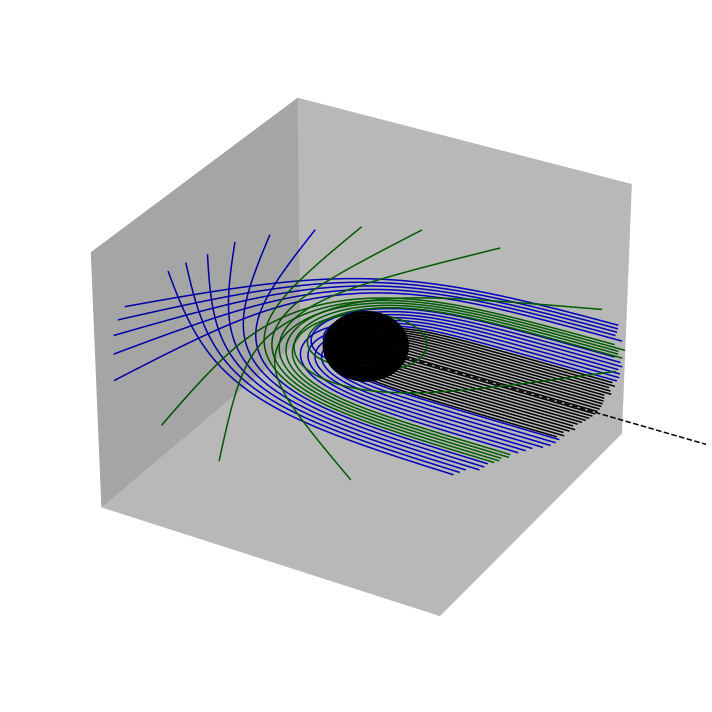

In [39]:
%matplotlib inline
fig, ax = plotgeos(sensor)

def cuboid_data(center, size):
    """
    Create a data array for cuboid plotting.


    ============= ================================================
    Argument      Description
    ============= ================================================
    center        center of the cuboid, triple
    size          size of the cuboid, triple, (x_length,y_width,z_height)
    :type size: tuple, numpy.array, list
    :param size: size of the cuboid, triple, (x_length,y_width,z_height)
    :type center: tuple, numpy.array, list
    :param center: center of the cuboid, triple, (x,y,z)

    """

    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array(x), np.array(y), np.array(z)

center = [0, 0, 0]
length = 18
width = 18
height = 18
X, Y, Z = cuboid_data(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='black', rstride=1, cstride=1, alpha=0.1)
plt.tight_layout()
# plt.savefig('figures/ray_illustration.pdf', transparent=False, bbox_inches=0)